In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from logger import logger
from mlflow_utils import evaluate_binary, plot_roc, plot_precision_recall

In [3]:
start_time = datetime.datetime.now()

In [4]:
INDEX = 'SNP'

### Import data

In [5]:
df = pd.read_csv('../datadir/{}.csv'.format(INDEX))

In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [8]:
df.sort_values(by='date', ascending=True, inplace=True)  # Have to sort ascending for rolling to work correctly

In [9]:
df.head()

,date,open,high,low,close,adj_close,volume
0,2019-03-04,2814.370117,2816.879883,2767.659912,2792.810059,2792.810059,3919810000
1,2019-03-05,2794.409912,2796.439941,2782.969971,2789.649902,2789.649902,3585690000
2,2019-03-06,2790.270020,2790.270020,2768.689941,2771.449951,2771.449951,3786600000
3,2019-03-07,2766.530029,2767.250000,2739.090088,2748.929932,2748.929932,3904860000
4,2019-03-08,2730.790039,2744.129883,2722.270020,2743.070068,2743.070068,3423130000


In [10]:
df.shape

(253, 7)

### Create basic features

In [11]:
df = df[['date', 'open', 'adj_close']].copy()

In [12]:
df['prev'] = df['adj_close'].shift(1)

In [13]:
df.head()

,date,open,adj_close,prev
0,2019-03-04,2814.370117,2792.810059,NaN
1,2019-03-05,2794.409912,2789.649902,2792.810059
2,2019-03-06,2790.270020,2771.449951,2789.649902
3,2019-03-07,2766.530029,2748.929932,2771.449951
4,2019-03-08,2730.790039,2743.070068,2748.929932


In [14]:
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()

In [15]:
df.head()

,date,open,adj_close,prev,sma2,sma5,sma10,sma20
0,2019-03-04,2814.370117,2792.810059,NaN,NaN,NaN,NaN,NaN
1,2019-03-05,2794.409912,2789.649902,2792.810059,NaN,NaN,NaN,NaN
2,2019-03-06,2790.270020,2771.449951,2789.649902,2791.229981,NaN,NaN,NaN
3,2019-03-07,2766.530029,2748.929932,2771.449951,2780.549926,NaN,NaN,NaN
4,2019-03-08,2730.790039,2743.070068,2748.929932,2760.189941,NaN,NaN,NaN


In [16]:
assert round(df['prev'].tail(5).mean(), 4) == round(df['sma5'].tail(1).item(), 4), 'Expected sma5 to be same as mean of past 5 items'
assert round(df['prev'].tail(10).mean(), 4) == round(df['sma10'].tail(1).item(), 4), 'Expected sma10 to be same as mean of past 10 items'
assert round(df['prev'].tail(20).mean(), 4) == round(df['sma20'].tail(1).item(), 4), 'Expected sma20 to be same as mean of past 20 items'

In [17]:
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [18]:
df.head()

,date,open,adj_close,prev,sma2,sma5,sma10,sma20,ema12,ema26
0,2019-03-04,2814.370117,2792.810059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-03-05,2794.409912,2789.649902,2792.810059,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-06,2790.270020,2771.449951,2789.649902,2791.229981,NaN,NaN,NaN,NaN,NaN
3,2019-03-07,2766.530029,2748.929932,2771.449951,2780.549926,NaN,NaN,NaN,NaN,NaN
4,2019-03-08,2730.790039,2743.070068,2748.929932,2760.189941,NaN,NaN,NaN,NaN,NaN


In [19]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price

In [20]:
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [21]:
df.dropna(inplace=True)

In [22]:
df.shape

(227, 16)

In [23]:
df.drop(columns=['date', 'open'], inplace=True)

### Create label

In [24]:
df['label'] = (df['adj_close'] > df['prev']).astype(int)

### Train-val split

### Keep most recent 20 days as validation set

In [25]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

[04/Dec/2021 23:27:51] INFO - No. of days - Train: 207, Val: 20


### Basic visualizations

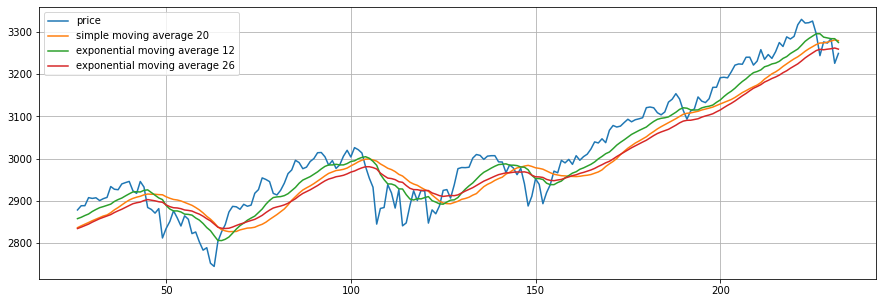

In [26]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['adj_close'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [27]:
scaler = StandardScaler()

In [28]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [29]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler()

In [30]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [31]:
train.head()

,adj_close,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,label
26,2878.199951,-0.822648,-0.832587,-0.920063,-1.114454,-1.259373,-1.101283,-1.284706,0.000523,0.004856,0.014100,0.020528,0.013149,0.021246,0
27,2888.209961,-0.951488,-0.886202,-0.903616,-1.068279,-1.223343,-1.076287,-1.256398,-0.003052,-0.001980,0.006006,0.013043,0.006028,0.014140,1
28,2888.320068,-0.878085,-0.914079,-0.881391,-1.004251,-1.191217,-1.042935,-1.223740,0.001733,0.000467,0.006583,0.015126,0.008016,0.016256,1
29,2907.409912,-0.877278,-0.876762,-0.867990,-0.947920,-1.158030,-1.014580,-1.193430,0.000019,-0.000114,0.004097,0.013781,0.006815,0.015087,1
30,2905.580078,-0.737294,-0.805965,-0.845976,-0.891489,-1.122727,-0.967317,-1.153070,0.003283,0.005444,0.008125,0.018796,0.011284,0.019957,0


In [32]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

[04/Dec/2021 23:27:52] INFO - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [33]:
results = smf.ols('adj_close ~ {}'.format(x_variables), data=train).fit()

In [34]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     578.1
Date:                Sat, 04 Dec 2021   Prob (F-statistic):          8.72e-147
Time:                        23:27:52   Log-Likelihood:                -930.76
No. Observations:                 207   AIC:                             1890.
Df Residuals:                     193   BIC:                             1936.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3041.1045     46.445     65.478      0.0

### Drop label col

In [35]:
train.drop(columns=['adj_close'], inplace=True)
val.drop(columns=['adj_close'], inplace=True)

### Logistic Regression Coefficients

In [36]:
y = train['label'].values
X = train.drop(columns=['label'])

In [37]:
X = add_constant(X)

In [38]:
logit = sm.Logit(y, X)

In [39]:
result = logit.fit()
print(result.summary())

         Current function value: 1.780240
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  207
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                           13
Date:                Sat, 04 Dec 2021   Pseudo R-squ.:                  -1.617
Time:                        23:27:53   Log-Likelihood:                -368.51
converged:                      False   LL-Null:                       -140.84
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3716     15.369      4.188      0.000      34.249      94.494
prev        -596.4932    150.250     -3.970      0.000    -890.97

D:\Softwares\miniconda3\envs\mlops\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Train some basic models

In [40]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

[04/Dec/2021 23:27:53] INFO - AUC: 0.303 | Recall: 0.889 | Precision: 0.444 | F1: 0.593


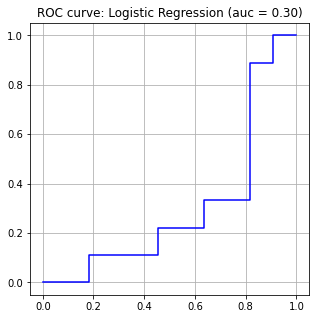

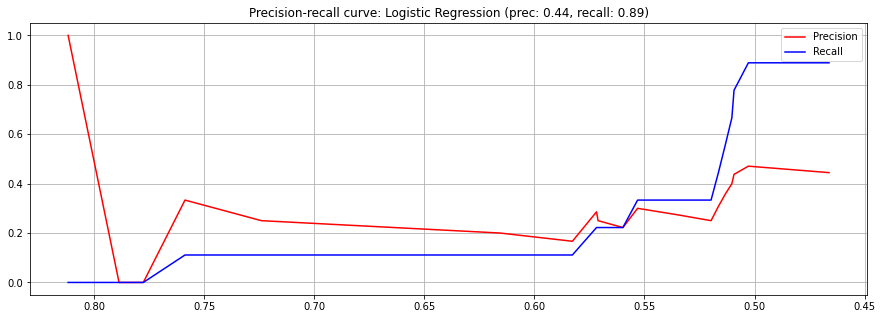

In [41]:
# Logistic regression
model_name = 'Logistic Regression'
model = LogisticRegression(fit_intercept=False).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
auc, recall, precision, f1  = evaluate_binary(y_val, pred)
plot_roc(y_val, pred, '{} (auc = {:.2f})'.format(model_name, auc))
plot_precision_recall(y_val, pred, '{} (prec: {:.2f}, recall: {:.2f})'.format(model_name, precision, recall))

[04/Dec/2021 23:27:54] INFO - AUC: 0.293 | Recall: 1.000 | Precision: 0.450 | F1: 0.621


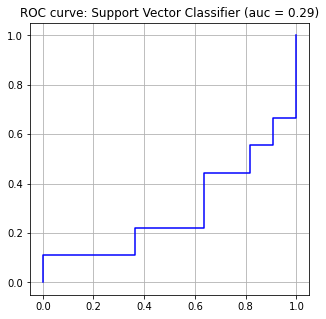

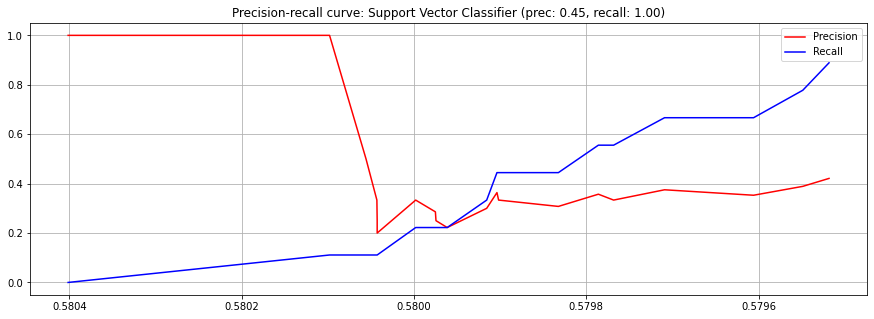

In [42]:
# Support vector classifier
model_name = 'Support Vector Classifier'
model = SVC(gamma=2, C=1, probability=True).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
auc, recall, precision, f1  = evaluate_binary(y_val, pred)
plot_roc(y_val, pred, '{} (auc = {:.2f})'.format(model_name, auc))
plot_precision_recall(y_val, pred, '{} (prec: {:.2f}, recall: {:.2f})'.format(model_name, precision, recall))

[04/Dec/2021 23:27:54] INFO - AUC: 0.480 | Recall: 0.333 | Precision: 0.429 | F1: 0.375


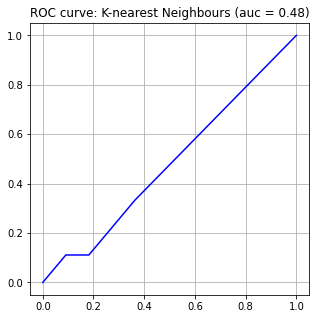

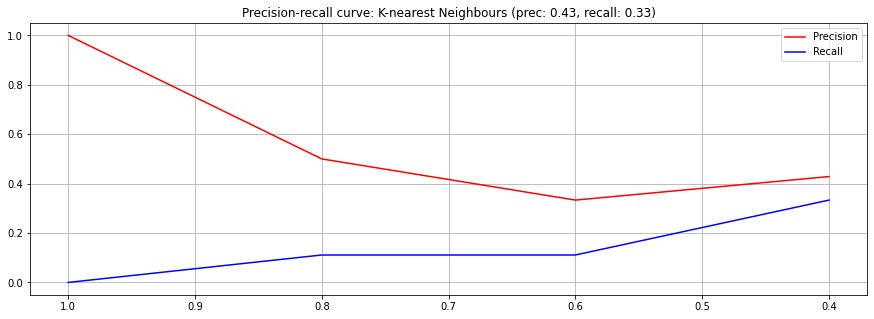

In [43]:
# K-neighbours
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(5).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
auc, recall, precision, f1  = evaluate_binary(y_val, pred)
plot_roc(y_val, pred, '{} (auc = {:.2f})'.format(model_name, auc))
plot_precision_recall(y_val, pred, '{} (prec: {:.2f}, recall: {:.2f})'.format(model_name, precision, recall))

[04/Dec/2021 23:27:55] INFO - AUC: 0.323 | Recall: 0.333 | Precision: 0.333 | F1: 0.333


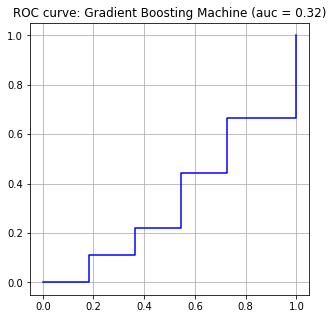

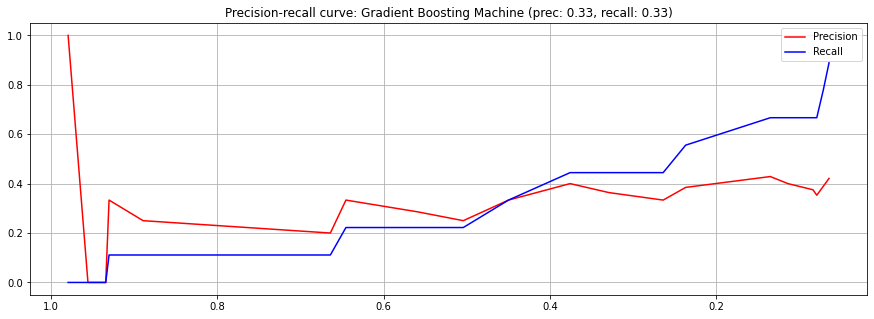

In [44]:
# Gradient Boosting
model_name = 'Gradient Boosting Machine'
model = GradientBoostingClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
auc, recall, precision, f1  = evaluate_binary(y_val, pred)
plot_roc(y_val, pred, '{} (auc = {:.2f})'.format(model_name, auc))
plot_precision_recall(y_val, pred, '{} (prec: {:.2f}, recall: {:.2f})'.format(model_name, precision, recall))

[04/Dec/2021 23:27:55] INFO - AUC: 0.429 | Recall: 0.333 | Precision: 0.375 | F1: 0.353


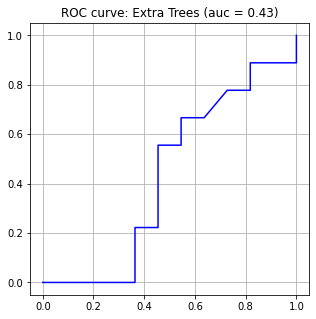

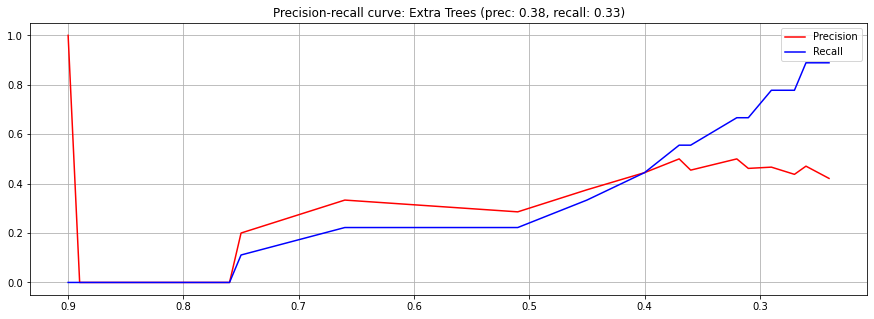

In [45]:
# Bagged trees
model_name = 'Extra Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
auc, recall, precision, f1  = evaluate_binary(y_val, pred)
plot_roc(y_val, pred, '{} (auc = {:.2f})'.format(model_name, auc))
plot_precision_recall(y_val, pred, '{} (prec: {:.2f}, recall: {:.2f})'.format(model_name, precision, recall))

In [46]:
end_time = datetime.datetime.now()
logger.info('Time taken (seconds): {}.{}'.format((end_time - start_time).seconds, (end_time - start_time).microseconds))

[04/Dec/2021 23:27:56] INFO - Time taken (seconds): 7.563758
